# Generate and Visualize Data

# Setup

## Import necessary libraries

In [20]:
import torch
import numpy as np

from neuralop.models import FNO1d
from matplotlib import pyplot as plt

# Generate Data

## Torch Dataset

In [ ]:
class BrownianMotionDataset(torch.utils.data.Dataset):
    def __init__(self,
                 N: int,
                 B: int=100, 
                 N_x: int=128,
                 X: tuple[float, float]=(0.0,1.0), 
                 T: float=1.0, 
                 D_range: tuple[float, float]=(1.0, 1.0), 
                 initial_condition: callable=None, 
                 transform: callable=None, 
                 as_prob: bool=False,
                 include_D: bool=False,
                 channels_first: bool=False,
                 seed: int=None, 
                 device: str | torch.device=None):
        """
        Dataset for 1D diffusion (Brownian motion) using closed‐form solution.

        Args:
            N: number of initial conditions (dataset size)
            B: number of time steps per trajectory
            N_x: number of spatial grid points
            X: The spatial domain
            T: total simulation time
            D_range: (min_D, max_D), sampled per sequence
            include_D: whether to include D as part of the input features
            channels_first: Whether to return (B, C, N_X) or (B, N_X, C)
            return_grid: Whether or not to return the mesh grid
            as_prob: whether or not to normalize u(x,t) to sum to 1 (ie interpret u(x, t) as a probability distribution)
            seed: base random seed for reproducibility
            transform: optional callable (u_in, u_out) -> (u_in_aug, u_out_aug)
            initial_condition: optional function x->u0(x); if provided, it is used for the IC
            device: torch device
        """
        super().__init__()
        self.N = N
        self.B = B
        self.N_x = N_x
        self.L = X[1] - X[0]
        self.X = X
        self.T = T
        self.D_range = D_range
        self.channels_first = channels_first
        self.as_prob = as_prob
        self.include_D = include_D
        self.seed = seed
        self.transform = transform
        self.initial_condition = initial_condition

        if isinstance(device, str):
            self.device = torch.device(device)
        elif device is None:
            self.device = torch.device("cpu")
        else: 
            self.device = device

        # Precompute the spatial and temporal grids.
        # Note: when using an IC function, we perform a convolution over spatial grid,
        # so we only need the 1D grid and a time vector.
        self.x = torch.linspace(X[0], X[1], N_x, device=self.device)  # shape: [N_x]
        self.dx = (self.L/(N_x-1))
        self.t = torch.linspace(0, T, B, device=self.device)      # shape: [B]
        # For the closed-form branch we also need a meshgrid; we create it later on
        # in the else branch.
        self.x_grid, self.t_grid = torch.meshgrid(self.x, self.t, indexing='ij')  # shapes: [N_x, B]
        self.xt_grid = torch.stack([self.x_grid, self.t_grid], axis=-1)
        if self.channels_first:
            self.xt_grid = self.xt_grid.permute(2,0,1)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        gen = torch.Generator(device=self.device)
        if self.seed is not None:
            gen.manual_seed(self.seed + idx)

        # Sample diffusion coefficient D for this trajectory
        D = torch.rand(1, generator=gen, device=self.device) * (self.D_range[1] - self.D_range[0]) + self.D_range[0]
        eps = 1e-8

        if self.initial_condition is not None:
            # Use the provided IC: u0 = initial_condition(x), shape [N_x]
            u0 = self.initial_condition(self.x)  # [N_x]
            u0 = u0 / u0.sum()
            dx = self.L / (self.N_x - 1)

            # The closed-form solution for diffusion with an arbitrary IC is
            #    u(x,t)=∫ K(x,x',t) u0(x') dx',
            # with the kernel
            #    K(x,x',t)= exp[-(x-x')^2/(4Dt)] / sqrt(4πDt).
            # We build a kernel for all time steps simultaneously.
            # Set up two copies of x for broadcasting:
            x_out = self.x.unsqueeze(1)  # shape: [N_x, 1]
            x_in  = self.x.unsqueeze(0)  # shape: [1, N_x]
            diff = x_out - x_in          # shape: [N_x, N_x]
            # Now set up a time vector for each time step.
            # t_exp: shape [1, 1, B]
            t_exp = self.t.unsqueeze(0).unsqueeze(0)
            # Now compute the kernel for all t:
            # kernel will have shape [N_x, N_x, B]
            kernel = torch.exp(- diff.unsqueeze(2)**2 / (4 * D * t_exp + eps)) / \
                     torch.sqrt(4 * torch.pi * D * t_exp + eps)
            # Now perform the convolution (sum over the integration variable x'):
            # u(x,t) = sum_{x'} kernel(x, x', t) * u0(x') * dx.
            u = torch.einsum('ijn,j->in', kernel, u0) * dx  # shape: [N_x, B]
            u = u.T.contiguous()  # reshape to [B, N_x]
            u[0] = u0
        else:
            # no initial_condition is provided: use random Gaussian parameters.
            x0 = torch.rand(1, generator=gen, device=self.device) * 0.5 + 0.25
            sigma = torch.rand(1, generator=gen, device=self.device) * 0.15 + 0.05
            # Here, we already have self.x_grid (shape: [N_x, B]) and self.t_grid (shape: [N_x, B])
            sigma_t = sigma**2 + 2 * D * self.t_grid  # shape: [N_x, B]
            u = 1. / torch.sqrt(2 * torch.pi * sigma_t) * torch.exp(
                - (self.x_grid - x0)**2 / (2 * sigma_t)
            )  # shape: [N_x, B]
            u = u.T.contiguous()  # shape: [B, N_x]

        # Now we create our trajectory pairs.
        # u has shape [B, N_x]; we want to predict u(t+1) from u(t):
        u_in = u[:-1].unsqueeze(-1)   # shape: [B-1, N_x, 1]
        u_out = u[1:].unsqueeze(-1)     # shape: [B-1, N_x, 1]

        # Apply any augmentations to the solution, if provided.
        if self.transform:
            u_in, u_out = self.transform(u_in, u_out)

        if self.as_prob:
            u_in = u_in / (u_in.sum(dim=1, keepdim=True) + 1e-8)  # Normalize by sum to 1
            u_out = u_out / (u_out.sum(dim=1, keepdim=True) + 1e-8)

        # Finally, if include_D is True, append D as an extra channel to u_in.
        if self.include_D:
            # D is a scalar here; expand it to match [B-1, N_x, 1] (unchanged in time and space)
            D_feat = D.expand(u_in.shape[0], u_in.shape[1], 1)
            u_in = torch.cat([u_in, D_feat], dim=-1)  # shape becomes [B-1, N_x, 2]

        if self.channels_first:
            u_in = u_in.permute(0,2,1)
            u_out = u_out.permute(0,2,1)

        return u_in.to(self.device), u_out.to(self.device), self.xt_grid


## Gaussian Noise Augmentations

In [59]:
class AddGaussianNoise:
    def __init__(self, std=0.01):
        self.std = std

    def __call__(self, u_in, u_out):
        noise = torch.randn_like(u_in) * self.std
        return u_in + noise, u_out

## Initial Conditions

In [60]:
def center_peak_ic(x, amplitude=1.0, width=0.1):
    """
    Generates an initial condition with a Gaussian peak centered in the middle of the domain.
    
    Parameters:
    - x (torch.Tensor): The spatial grid, a 1D tensor representing spatial points.
    - amplitude (float): The peak value at the center (default: 1.0).
    - width (float): The width of the peak. Controls how quickly the value decays away from the center (default: 0.1).
    
    Returns:
    - torch.Tensor: The initial condition profile with a peak at the center of the domain.
    """
    
    # Calculate the distance from the center (center is x[len(x) // 2])
    distance = torch.abs(x - x[len(x) // 2])
    
    # Define the Gaussian profile
    profile = torch.exp(-distance**2 / (2 * width**2))
    
    # Scale by the amplitude to set the peak value at the center
    return amplitude * profile

In [61]:
def delta_ic_gaussian(x_grid, center=0.5, sigma=0.05):
    """
    Approximates a Dirac delta centered at `center` using a narrow Gaussian.
    
    Args:
        x_grid (torch.Tensor): (N_x,) spatial grid
        center (float): location of the spike (default 0.5)
        sigma (float): width of the Gaussian (default 0.01)
    
    Returns:
        u0 (torch.Tensor): (N_x,) normalized initial condition
    """
    u0 = torch.exp(-0.5 * ((x_grid - center) / sigma) ** 2)
    u0 = u0 / (u0.sum() * (x_grid[1] - x_grid[0]))  # normalize to integrate to 1
    return u0

# Visualize

## Instantiate Dataset

In [62]:
ds = BrownianMotionDataset(
    N=1000, include_D=False, seed=42,
    initial_condition=delta_ic_gaussian, as_prob=True
)

## Inspect Shapes

In [64]:
u_t, u_t_1, grid = ds[1]
u_t.shape, u_t_1.shape, grid.shape

(torch.Size([99, 128, 1]), torch.Size([99, 128, 1]), torch.Size([128, 100, 2]))

## Visualize

Text(0.02, 0.5, 'x')

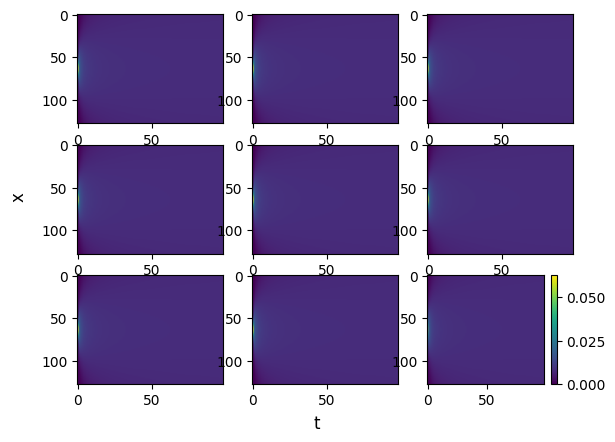

In [65]:
fig, axs = plt.subplots(3,3)
k=0
for i in range(3):
    for j in range(3):
        traj_t, traj_t_1, _ = ds[k]
        #print(traj_t.sum(axis=1))
        im = axs[i,j].imshow(traj_t.squeeze().T, aspect="auto")
        k+=1
fig.colorbar(im)
fig.supxlabel("t")
fig.supylabel("x")

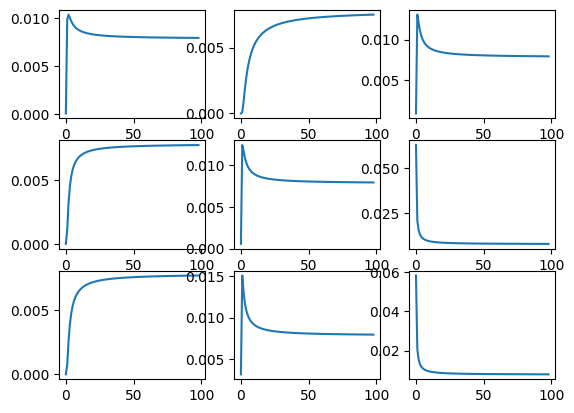

In [66]:
fig, axs = plt.subplots(3,3)
k=0
for i in range(3):
    for j in range(3):
        traj_t, traj_t_1, _ = ds[k]
        #print(traj_t.sum(axis=1).shape)
        axs[i,j].plot(traj_t[:, np.random.choice(np.arange(traj_t.shape[1])), 0].squeeze())
        k+=1

# Pass through FNO Model

## Instantiate Model

In [67]:
model = FNO1d(n_modes_height=16, in_channels=1, hidden_channels=16, out_channels=1)

In [68]:
model(ds[0][0].permute(0,2,1)).shape

torch.Size([99, 1, 128])